# Imports

In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

import wandb

In [164]:
wandb.login()

True

In [165]:
wandb_run = wandb.init(project="CovidForecaster")

# Utils

In [166]:
def compare(dataframe, fields):
    fig, ax = plt.subplots(figsize=(10,10))
    for f in fields:
        ax.plot(dataframe["Date"], dataframe[f], label=f)
    ax.legend(loc="best")

In [167]:
def mobility_check(df, where, what, everything=False, save=False):
    fig, ax = plt.subplots(figsize=(10,10))
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    ax.plot(df[df["State"]==where]["Date"], sc.fit_transform(df[df["State"]==where]["new cases"].to_numpy().reshape(-1, 1)), label=f"Cases @ {where}")
    sc = StandardScaler()
    ll = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',]
    if everything:
        for l in ll:
            ax.plot(df[df["State"]==where]["Date"], sc.fit_transform(df[df["State"]==where][l].to_numpy().reshape(-1, 1)), label=l)
    else:
        ax.plot(df[df["State"]==where]["Date"], sc.fit_transform(df[df["State"]==where][what].to_numpy().reshape(-1, 1)), label=what)
    ax.legend(loc="best")
    if save:
        plt.savefig(f"{where},{what if not everything else ''}.png")

# Data Collection and Analysis

In [168]:
df = pd.read_csv("data/state_mobility_cases_agg=max_2020.csv")
df["Date"]=pd.to_datetime(df["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10523 entries, 0 to 10522
Data columns (total 9 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   Date                                                10523 non-null  datetime64[ns]
 1   State                                               10523 non-null  object        
 2   retail_and_recreation_percent_change_from_baseline  10176 non-null  float64       
 3   grocery_and_pharmacy_percent_change_from_baseline   9870 non-null   float64       
 4   parks_percent_change_from_baseline                  10448 non-null  float64       
 5   transit_stations_percent_change_from_baseline       10171 non-null  float64       
 6   workplaces_percent_change_from_baseline             10520 non-null  float64       
 7   residential_percent_change_from_baseline            10254 non-null  float64       
 8   new cas

In [169]:
scaler = StandardScaler()
df_no_date_no_place = df.drop(["Date", "State"], axis=1)
df[df_no_date_no_place.columns] = scaler.fit_transform(df[df_no_date_no_place.columns])
df

,Date,State,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,new cases
0,2020-03-14,Andaman and Nicobar Islands,0.291569,-0.774992,-0.395025,-0.181550,-0.108450,-1.549277,-0.467251
1,2020-03-14,Andhra Pradesh,0.674130,-0.387750,-0.175257,-0.060094,-0.170492,-1.793147,-0.466772
2,2020-03-14,Arunachal Pradesh,0.817591,-0.559858,0.122999,-0.181550,0.356866,-1.915082,-0.467251
3,2020-03-14,Assam,0.793681,-0.373408,0.028813,0.349821,0.387887,-1.915082,-0.467251
4,2020-03-14,Bihar,0.961052,-0.100905,0.264278,0.273911,0.170739,-0.939603,-0.467251
...,...,...,...,...,...,...,...,...,...
10518,2020-12-31,Telangana,0.793681,0.773975,0.044510,0.243547,0.108697,-0.939603,-0.268683
10519,2020-12-31,Tripura,0.554580,0.071203,0.750907,1.169650,0.791160,-0.939603,-0.464380
10520,2020-12-31,Uttar Pradesh,1.080602,1.448062,0.829395,0.440913,0.698097,0.035877,-0.467251
10521,2020-12-31,Uttarakhand,1.869635,0.702263,1.818350,1.518837,0.915244,-0.207993,-0.321794


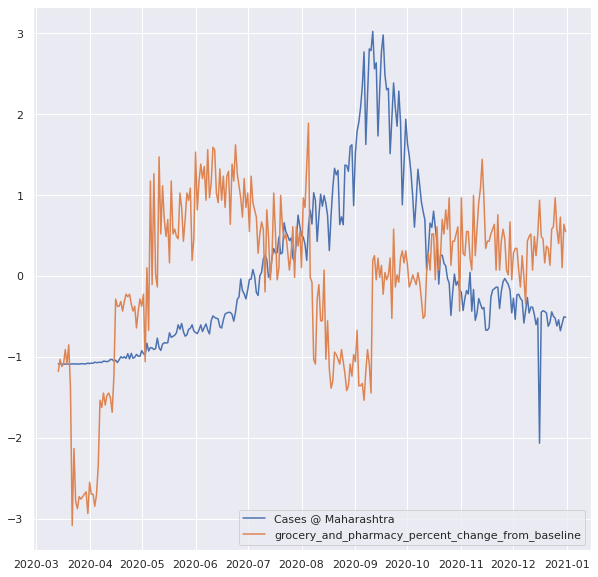

In [170]:
mobility_check(df,"Maharashtra", "grocery_and_pharmacy_percent_change_from_baseline")

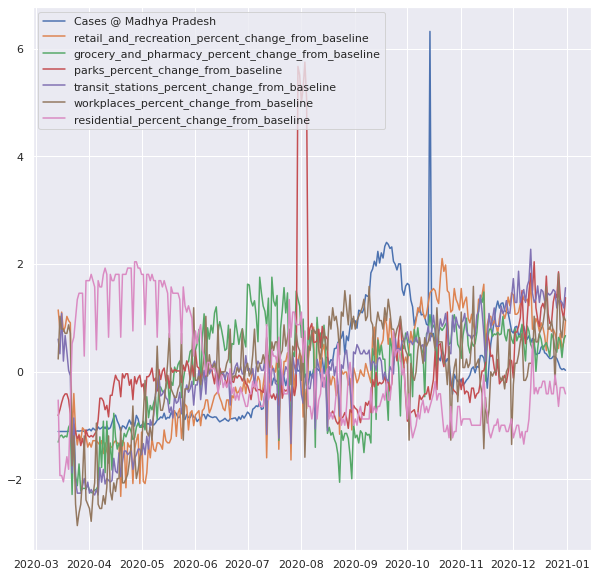

In [171]:
mobility_check(df, "Madhya Pradesh", "grocery_and_pharmacy_percent_change_from_baseline", True, True)

# Algorithm Developement

In [172]:
def sliding_window(data, seq_len):

    xs = []
    ys = []
    for i in range(len(data)-seq_len-1):
        x = data[i:(i+seq_len)].drop(["Date"], axis=1).to_numpy().flatten()
        y = data[(i+seq_len):i+seq_len+1]["new cases"].to_numpy()[0]
        xs.append(x)
        ys.append(y)

  
    return np.array(xs, dtype=np.float64), np.array(ys, dtype=np.float64)

In [173]:
class CoronaVirusPredictor(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
#         print("Forward Starts\n-------")
#         print(f"{sequences.shape}")
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
#         print(lstm_out.shape)
#         print(f"lstm_out.view(self.seq_len, len(sequences), self.n_hidden):{lstm_out.view(self.seq_len, len(sequences), self.n_hidden).shape}")
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
#         print("##")
#         print(lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1:].shape)
#         print(lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1].shape)
#         print("##")
#         print(f"##{last_time_step.shape}##")
        y_pred = self.linear(last_time_step)
#         print(y_pred.shape)
#         print("Forward Ends\n-------")
        return y_pred

In [174]:
def train_model(
        model, 
        train_data, 
        train_labels, 
        test_data=None, 
        test_labels=None
    ):
    loss_fn = torch.nn.MSELoss(reduction='sum')

    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 60

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        model.reset_hidden_state()

        y_pred = model(X_train)

        loss = loss_fn(y_pred.float().flatten(), y_train)

        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
                test_hist[t] = test_loss.item()

            if t % 10 == 0:  
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t] = loss.item()

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

    return model.eval(), train_hist, test_hist

In [175]:
tscv = TimeSeriesSplit()

Error: You must call wandb.init() before wandb.log()

In [184]:
model = CoronaVirusPredictor(
  n_features=7, 
  n_hidden=64, 
  seq_len=1, 
  n_layers=2
)

wandb.watch(model)

from tqdm.notebook import trange

def train_model_with_crossval(
        model, 
        data, 
        labels,
        tscv,
    ):
    model = model.float()
    
    r2_scores, test_error_mse, test_error_mae = [], [], []
    train, test = {}, {}
    train['feats'], train['pred'], train['true'] = {}, {}, {}
    test['feats'], test['pred'], test['true'] = {}, {}, {}

    v = 0
    for train_index, test_index in tscv.split(data):
        v += 1
#         print(train_index.shape, test_index.shape)
        X_train, y_train = torch.from_numpy(data[train_index]), torch.from_numpy(labels[train_index])
        X_test, y_test = torch.from_numpy(data[test_index]), torch.from_numpy(labels[test_index])
        
        train['feats'][v] = X_train.numpy()
        test['feats'][v] = X_test.numpy()
#         print(X_train.shape, y_train.shape)
    
    
        loss_fn = torch.nn.L1Loss(reduction='sum')
        loss_fn2 = torch.nn.MSELoss(reduction='sum')

        optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
        num_epochs = 60

        train_hist = np.zeros(num_epochs)
        test_hist = np.zeros(num_epochs)

        for t in (trange(num_epochs)):
            model.train()
            model.reset_hidden_state()
#             print(f"Inp Shape: {X_train.shape}")
            y_pred = model(X_train.float()).squeeze()

            loss = loss_fn2(y_pred.float().flatten(), y_train.float())
            wandb.log({f"train_loss{v}": loss.item()})
            train_hist[t] = loss.item()

            optimiser.zero_grad()

            loss.backward()

            optimiser.step()
        
        with torch.no_grad():
            y_train_pred = model(X_train.float()).squeeze()

            train['pred'][v] = y_train_pred.numpy().tolist()
            train['true'][v] = y_train.numpy().tolist()
            model.eval()
            y_test_pred = model(X_test.float()).squeeze()

            test['pred'][v] = y_test_pred.numpy().tolist()
            test['true'][v] = y_test.numpy().tolist()

            test_error_mae.append(loss_fn(y_test_pred.float(), y_test).item())
            test_error_mse.append(loss_fn2(y_test_pred.float(), y_test).item())
            r2_scores.append(r2_score(y_test.numpy(), y_test_pred.float().numpy()))
#     print(v)
                


    return r2_scores, test_error_mae, test_error_mse, train, test

X, y = sliding_window(df[df["State"]=="Maharashtra"].drop("State", axis=1), 1)
# X = torch.from_numpy(X).float()
# y = torch.from_numpy(y).float()
r2_scores, test_error_mae, test_error_mse, train, test = train_model_with_crossval(
    model, 
    X, 
    y,
    tscv,
)

# def cross_val()

In [181]:
wandb.log({"r2_scores": r2_scores, "test_error_mae":test_error_mae, "test_error_mse":test_error_mse})

In [182]:
r2_scores, test_error_mae, test_error_mse

([-3.582041907930944,
  -3.292319638903936,
  -1.7383187717277826,
  -3.71038153955112,
  -0.07893566701918586],
 [35.700473642316375,
  92.35129753942317,
  142.85570242533046,
  199.48683894663128,
  28.15554839246488],
 [32.819046315936404,
  221.8143725312691,
  627.9635352643229,
  978.5193151291787,
  38.806290966570266])

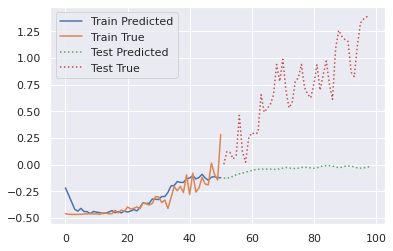

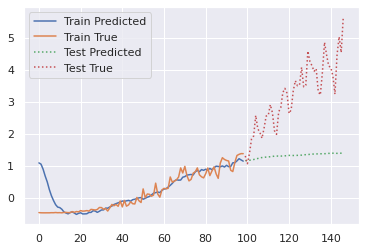

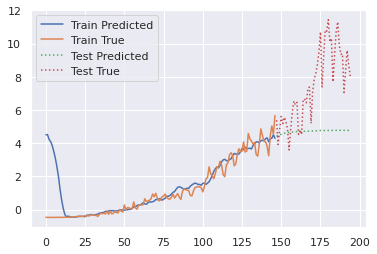

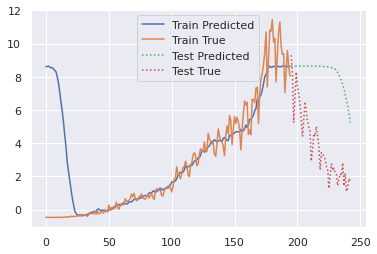

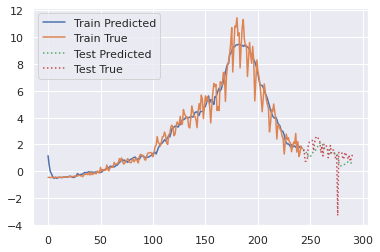

In [188]:
for i in range(1,6):
    plt.plot(list(range(0,len(train['pred'][i]))),train['pred'][i],label='Train Predicted')
    plt.plot(list(range(0,len(train['true'][i]))),train['true'][i],label='Train True')

    plt.plot(list(range(len(train['pred'][i]),len(train['pred'][i])+len(test['pred'][i]))),test['pred'][i],label='Test Predicted', linestyle='dotted')
    plt.plot(list(range(len(train['true'][i]),len(train['true'][i])+len(test['true'][i]))),test['true'][i],label='Test True', linestyle='dotted')
    
    plt.legend()
    wandb.log({f"chart{i}": wandb.Image(plt)})
    plt.show()

IndexError: index 7 is out of bounds for axis 1 with size 7

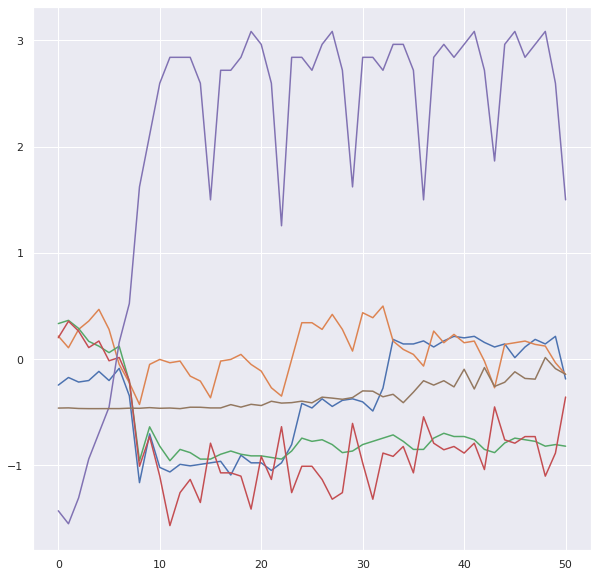

In [157]:
fig, ax = plt.subplots(figsize=(10,10))
v = 1
for i in range(1,10):  
    plt.plot(list(range(0,len(train['feats'][v]))),train['feats'][v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(train['true'][v]))),train['true'][v],label='True',linewidth=5)
plt.plot(list(range(0,len(train['pred'][v]))),train['pred'][v],label='Predicted',linewidth=5)

plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(10,10))
v = 1
for i in range(10,20):  
    plt.plot(list(range(0,len(train['feats'][v]))),train['feats'][v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(train['true'][v]))),train['true'][v],label='True',linewidth=5)
plt.plot(list(range(0,len(train['pred'][v]))),train['pred'][v],label='Predicted',linewidth=5)

plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(10,10))
v = 1
for i in range(20,31):  
    plt.plot(list(range(0,len(train['feats'][v]))),train['feats'][v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(train['true'][v]))),train['true'][v],label='True',linewidth=5)
plt.plot(list(range(0,len(train['pred'][v]))),train['pred'][v],label='Predicted',linewidth=5)

plt.legend()
plt.show()

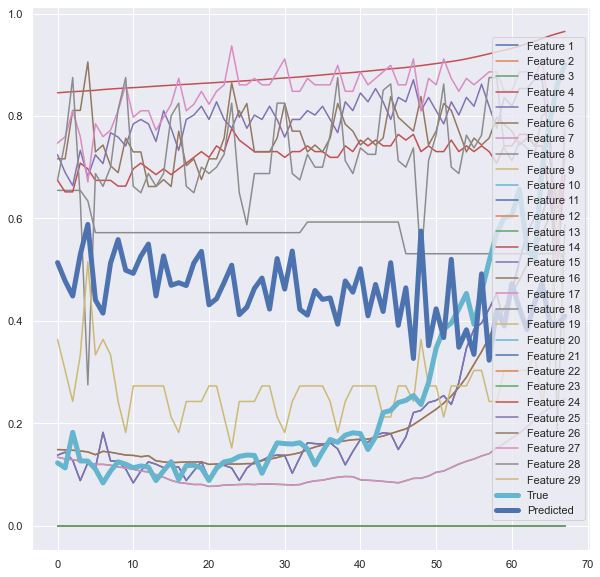

In [172]:
fig, ax = plt.subplots(figsize=(10,10))
v = 5
for i in range(1,30):  
    plt.plot(list(range(0,len(train[v]))),train[v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(test[v]))),test[v],label='True',linewidth=5)
plt.plot(list(range(0,len(pred[v]))),pred[v],label='Predicted',linewidth=5)

plt.legend()
plt.show()

In [158]:
wandb_run.finish()

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


params,todo
_runtime,72
_timestamp,1618920425
_step,0


_runtime,▁
_timestamp,▁
_step,▁
